In [2]:
import scanpy as sc
import numpy as np
import warnings 
warnings.filterwarnings ("ignore")
import re, random
from pathlib import Path
import json
import pandas as pd
from pandas import DataFrame
import os, sys
import torch
import TOSICA 
from icecream import ic
ic.configureOutput(includeContext=True, argToStringFunction=lambda _: str(_))


Information of GPU

In [19]:
# print(torch.cuda.get_device_capability(device=None),  torch.cuda.get_device_name(device=None))

1.13.1


Reference data

In [3]:
root_data_dir = Path('data')
data_type = 'hPancreas'
data_dir = root_data_dir / data_type
data_file = data_dir / 'demo_train.h5ad'
ref_adata = sc.read(data_dir / 'demo_train.h5ad')
gene_names = set(ref_adata.var_names)
ic(len(gene_names))
print(ref_adata.var_names[:5])
print(ref_adata.obs_names[:5])
# view of the data
ref_adata = ref_adata[:, ref_adata.var_names]
print(ref_adata)
print(ref_adata.obs.Celltype.value_counts())

a = ref_adata[['human1_lib1.final_cell_0001', 'human1_lib1.final_cell_0003'], ['COL1A1', 'COL1A2', 'PPY', 'CTRB1']]
print(a)
b = a.X.toarray().tolist()
print(b)

04-18 21:06:38 attrs.py 77: Creating converter from 3 to 5
ic| 3701846396.py:7 in <module>- len(gene_names): 3000


Index(['COL1A1', 'COL1A2', 'PPY', 'CTRB1', 'CELA3A'], dtype='object')
Index(['human1_lib1.final_cell_0001', 'human1_lib1.final_cell_0003',
       'human1_lib1.final_cell_0004', 'human1_lib1.final_cell_0005',
       'human1_lib1.final_cell_0006'],
      dtype='object')
View of AnnData object with n_obs × n_vars = 10600 × 3000
    obs: 'Celltype'
    var: 'Gene Symbol'
alpha          3136
beta           2966
ductal         1290
acinar         1144
delta           793
PSC             524
PP              356
endothelial     273
macrophage       52
mast             25
epsilon          21
schwann          13
t_cell            7
Name: Celltype, dtype: int64
View of AnnData object with n_obs × n_vars = 2 × 4
    obs: 'Celltype'
    var: 'Gene Symbol'
[[0.0, 0.0, 1.0241609811782837, 5.755773067474365], [0.0, 0.0, 0.7810583114624023, 6.0262041091918945]]


Query data

In [9]:
query_adata = sc.read(data_dir / 'demo_test.h5ad')
query_adata = query_adata[:,ref_adata.var_names]
print(query_adata)
print(query_adata.obs.Celltype.value_counts())
print(query_adata.shape)
# type(query_adata.var['Gene Symbol'])) is Series

View of AnnData object with n_obs × n_vars = 4218 × 3000
    obs: 'Celltype'
    var: 'Gene Symbol'
alpha           2011
beta            1006
ductal           414
PP               282
acinar           209
delta            188
PSC               73
endothelial       16
epsilon            7
mast               7
MHC class II       5
Name: Celltype, dtype: int64
(4218, 3000)


Training:

In [27]:
TOSICA.train(ref_adata, gmt_path='human_gobp', label_name='Celltype', epochs=3, project='hGOBP_demo')
!ls ./hGOBP_demo

cpu
Mask loaded!
Model builded!


[train epoch 0] loss: 2.578, acc: 0.075:  16%|█▌        | 816/5096 [19:40<1:43:10,  1.45s/it] 


RuntimeError: [enforce fail at C:\cb\pytorch_1000000000000\work\c10\core\impl\alloc_cpu.cpp:72] data. DefaultCPUAllocator: not enough memory: you tried to allocate 172800000 bytes.

Prediction

In [6]:
model_weight_path = './hGOBP_demo/model-0.pth'
new_adata = TOSICA.pre(query_adata, model_weight_path = model_weight_path,project='hGOBP_demo')

cuda:0
0
4218


the X data in predicted new_adata is the attention weight, thats 4218 * 299, the 299 pathways has most genes.

In [7]:
new_adata.write('demo_attn.h5ad')
new_adata

AnnData object with n_obs × n_vars = 4218 × 299
    obs: 'Prediction', 'Probability', 'Celltype'
    var: 'pathway_index'

In [8]:
new_adata.raw = new_adata
sc.pp.normalize_total(new_adata, target_sum=1e4)
sc.pp.log1p(new_adata)
sc.pp.scale(new_adata, max_value=10)
sc.tl.pca(new_adata, svd_solver='arpack')
sc.pp.neighbors(new_adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(new_adata)

In [9]:
col = np.array([
"#98DF8A","#E41A1C" ,"#377EB8", "#4DAF4A" ,"#984EA3" ,"#FF7F00" ,"#FFFF33" ,"#A65628" ,"#F781BF" ,"#999999","#1F77B4","#FF7F0E","#279E68","#FF9896"
]).astype('<U7')

celltype = ("alpha","beta","ductal","acinar","delta","PP","PSC","endothelial","epsilon","mast","macrophage","schwann",'t_cell')
new_adata.obs['Prediction'] = new_adata.obs['Prediction'].astype('category')
new_adata.obs['Prediction'] = new_adata.obs['Prediction'].cat.reorder_categories(list(celltype))
new_adata.uns['Prediction_colors'] = col[1:]

celltype = ("MHC class II","alpha","beta","ductal","acinar","delta","PP","PSC","endothelial","epsilon","mast")
new_adata.obs['Celltype'] = new_adata.obs['Celltype'].astype('category')
new_adata.obs['Celltype'] = new_adata.obs['Celltype'].cat.reorder_categories(list(celltype))
new_adata.uns['Celltype_colors'] = col[:11]

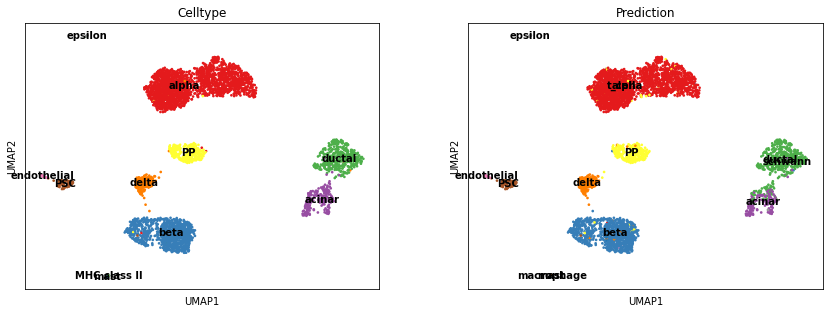

In [10]:
sc.pl.umap(new_adata, color=['Celltype', 'Prediction'],legend_loc='on data')

Training on pre-weights of 'human_gobp' mask:

In [11]:
!cp ./hGOBP_demo/model-0.pth ./pre_weights.pth

In [12]:
TOSICA.train(ref_adata, gmt_path='human_gobp', label_name='Celltype',pre_weights='pre_weights.pth',epochs=1)

cuda:0
Mask loaded!
<All keys matched successfully>
Model builded!


[valid epoch 0] loss: 0.040, acc: 0.992: 100%|██████████| 5096/5096 [00:31<00:00, 162.61it/s]


Training finished!
